In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.MNIST_model import MNIST_model
from src.MNIST_dataset import MNISTDataset
from src.train_config import Config as cfg

In [32]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
    (0.1307,), (0.3081,))
])

train_dataset = MNISTDataset('/files/', train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

validation_dataset = MNISTDataset('/files/', train=False, transform=transform)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=cfg.batch_size, shuffle=True)

print(f"Train: {len(train_dataset)}, Validation: {len(validation_dataset)}")

Train: 60000, Validation: 10000


In [33]:
val_sample = next(iter(validation_dataloader))
val_sample_data, val_sample_target = val_sample[0][0:1], val_sample[1][0].item()

In [34]:
model = MNIST_model().to(cfg.device)
model.load_state_dict(torch.load(
    'results/model05_3iters_28_28/best_model_state_model05_3iters.h5'
))
model = model.eval()
model

MNIST_model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [35]:
class Hook():
    def __init__(self,m):
        self.hook = m.register_forward_hook(self.hook_func)
    def hook_func(self,m,i,o):
        self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args):
        self.hook.remove()

In [36]:
with Hook(model._modules.get('conv2')) as hook:
    # with torch.no_grad():
    output = model.eval()(val_sample_data.to(cfg.device))
    act = hook.stored
print(act.shape)

torch.Size([1, 32, 28, 28])


In [37]:
# pred = torch.sigmoid(output).cpu()
# print(pred)
# print(val_sample_target)
pred = F.softmax(output, dim=1).cpu()
print(pred)
print(val_sample_target)

tensor([[5.7434e-11, 2.2573e-14, 1.9855e-14, 1.5053e-12, 3.6194e-15, 1.0000e+00,
         1.8267e-11, 4.2185e-10, 4.9768e-08, 3.6422e-13]],
       grad_fn=<ToCopyBackward0>)
5


In [38]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data)
weight_softmax.shape

torch.Size([10, 32])

In [39]:
for param in params:
    print(param.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([32, 25088])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [40]:
act[0].shape

torch.Size([32, 28, 28])

In [41]:
cam_map = torch.einsum('ck,kij->cij', weight_softmax, act[0])
cam_map.shape

torch.Size([10, 28, 28])

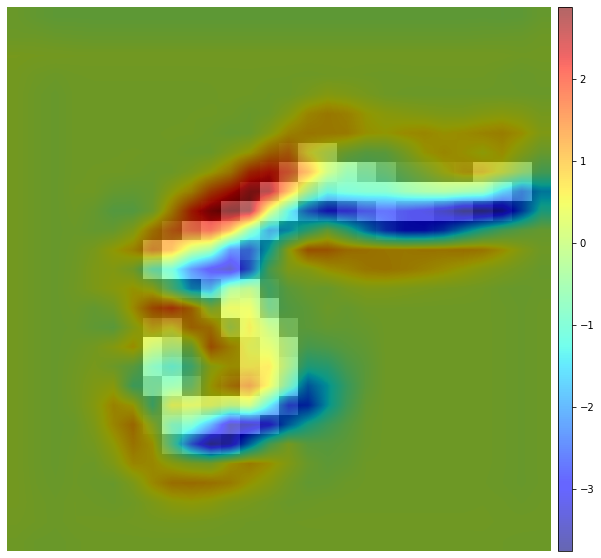

In [48]:
from fastai.vision.all import *
x_dec = TensorImage(val_sample_data[0][0])
fig, ax = plt.subplots(figsize=(10,10))
x_dec.show(ctx=ax, cmap='gray')
plot = ax.imshow(cam_map[val_sample_target].detach().cpu(), alpha=0.6
                #  , extent=(0,28,28,0)
                 , interpolation='bilinear', cmap='jet')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(plot, cax=cax)
plt.show()

<AxesSubplot:>

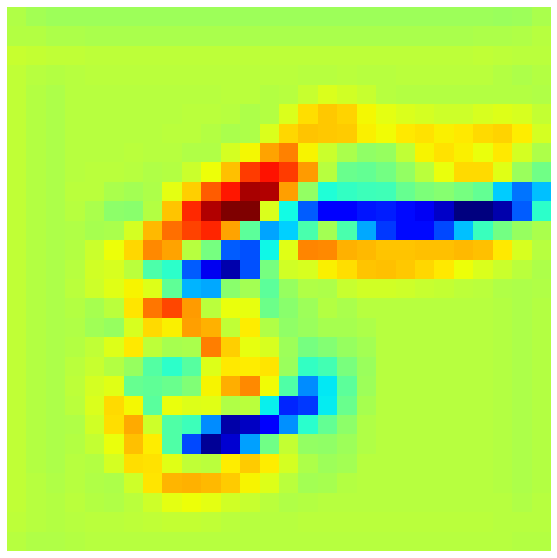

In [49]:
cam_map_sample = TensorImage(cam_map[val_sample_target].detach().cpu())
_,ax = plt.subplots(figsize=(10,10))
cam_map_sample.show(ctx=ax, cmap='jet')